In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
from collections import Counter
np.random.seed(42)

In [9]:
#helper functions

def arm_dist_draw(arm):
    """
    Sample according to the arm's distribution then return the reward
    """
    global Arm_parameters

    if arm==len(Arm_parameters)-1:
        return np.random.uniform(0, 1, size=1)[0]*10

    mu, std = Arm_parameters[arm]
    lower = 0
    upper = 1
    return scipy.stats.truncnorm.rvs(
                (lower-mu)/std,(upper-mu)/std,loc=mu,scale=std,size=1)[0]*10

In [10]:
#in what follows we order arm from 0 to 7 and call them by their indices 
# arm 0 means the first arm

##experiments settings
NUM_ARMS = 8 #number of arms
TT_PULLS = 400 #total number of pulls
NUM_TRIALS = 1000

mu_0, std_0 = 5, 10  #first arm Gaussian's parameters
mu_1, std_1 = 3, 2
mu_2, std_2 = 10, 3
mu_3, std_3 = 7, 5
mu_4, std_4 = 0, 5
mu_5, std_5 = 1, 1
mu_6, std_6 = 10, 10
low_7, high_7 = 0, 1 #last arm draws from uninofrm [0, 1)
#the rewards are the drawn samples times 10 ([0, 1])
Arm_parameters = [(mu_0, std_0), (mu_1, std_1), (mu_2, std_2), (mu_3, std_3), (mu_4, std_4),
                  (mu_5, std_5), (mu_6, std_6), (low_7, high_7)]




#the expected reward of every arm is its mu value, except the 8-th arm its expected reward is 5
Arms_expected_rewards = [mu_0, mu_1, mu_2, mu_3, mu_4, mu_5, mu_6, 5]
print("Arms_expected_rewards: ", Arms_expected_rewards)

#the optimal arm is 2 because it gives the expected reward of 10 with a small std 1
Opt_arm_expected_reward = Arms_expected_rewards[2]

Arms_expected_rewards:  [5, 3, 10, 7, 0, 1, 10, 5]


In [3]:
def run_alg_exp(algorithm=0, epsilon=None, printt=True, returnn=True):
    
    global NUM_ARMS, NUM_TRIALS, TT_PULLS, Arms_expected_rewards, Opt_arm_expected_reward

    """
    Run experiment by the chosen algorithm.
    0: Incremental Uniform,
    1: UCB,
    2: epsilon-Greedy
    """

    #best arms per trial
    best_arms = np.zeros(NUM_TRIALS)

    #regret history
    simple_regret_history = []
    cumulative_regret_history = []

    for t in range(NUM_TRIALS):
        if printt: 
            print(f'Running trial {t}...')

        #initial variables
        running_sum_rewards = np.zeros(NUM_ARMS, dtype=float) #accumulated sum of rewards
        average_rewards = np.zeros(NUM_ARMS, dtype=float)     #avgs
        num_pulls = np.zeros(NUM_ARMS, dtype=int)             #num of pulls per arm
        total_pulls = 0                                       #total number of pulls used so far
        best_arm = np.random.randint(0, NUM_ARMS-1)           #randomly choosing an arm as the initial best one

        #initialization of regret history per trial (over all pulls)
        temp1 = [] #to store simple regret history during the pulls
        temp2 = [] #to store cumulative regret history during the pulls
        temp_n = 0 #counter
        expected_cumulative_reward = 0 #cumulative regret initialized at 0

        for p in range(TT_PULLS):
            #Incremental Uniform
            if algorithm==0:
                pulled_arm = total_pulls % NUM_ARMS

            #UCB
            elif algorithm==1:
                #pulling all arms in the first 8-pulls to avoid divide by zero
                if total_pulls < NUM_ARMS:
                    pulled_arm = total_pulls % NUM_ARMS
                else:
                    averages = average_rewards
                    numerator = 2.*np.log(total_pulls)
                    ratio = np.divide(numerator, num_pulls)
                    exploration_term = np.sqrt(ratio)
                    pulled_arm = np.argmax(averages + exploration_term)
            
            #epsilon-Greedy
            elif algorithm==2:
                if np.random.uniform(0, 1) <= epsilon:
                    pulled_arm = best_arm
                else:
                    other_arms = list(set(range(NUM_ARMS)) - set([best_arm]))
                    pulled_arm = np.random.choice(other_arms)

            else: 
                print("The chosen algorithm is not supported!")
                return


            reward = arm_dist_draw(pulled_arm)
            # print("pulled arm: ", pulled_arm)
            # print("pulled arm reward: ", reward)

            #update best_arm
            running_sum_rewards[pulled_arm] += reward
            num_pulls[pulled_arm] += 1
            total_pulls += 1
            average_rewards = np.divide(running_sum_rewards, num_pulls) #update avg rewards
            average_rewards[np.isinf(average_rewards)] = 0
            average_rewards[np.isnan(average_rewards)] = 0
            # print("avg rewards: ", list(average_rewards))

            best_arm = np.argmax(average_rewards) # update best arm after this pull
            # print("best arm: ", best_arm)

            # save regret's history{
            expected_reward_pulled_arm = Arms_expected_rewards[pulled_arm]
            expected_reward_best_arm = Arms_expected_rewards[best_arm]

            expected_cumulative_reward = expected_cumulative_reward + expected_reward_pulled_arm #increase cumulative regret
            temp_n += 1

            #calculate simple regret at this pull
            temp1.append(Opt_arm_expected_reward - expected_reward_best_arm)
            #calculate cumulative regret at this pull
            temp2.append(temp_n*Opt_arm_expected_reward - expected_cumulative_reward)
            #}
            # print("simple regret: ", temp1)
            # print("cumulative regret: ", temp2)
            # print()

        
        simple_regret_history.append(temp1)
        cumulative_regret_history.append(temp2)


        if printt:
            print(f'best arm: {best_arm}')
        best_arms[t] = best_arm

    print("Best arms: ")
    print(Counter(best_arms))

    #return mean over trials
    if returnn:
        return np.mean(np.array(simple_regret_history), axis=0), np.mean(np.array(cumulative_regret_history), axis=0)

#Arms_expected_rewards = [5, 3, 10, 7, 0, 1, 10, 5]

def plot(X, Y, name):
    plt.figure(figsize=(14, 10))
    algs = ['Incremental Uniform', 'UCB', '0.5-Greedy', '0.9-Greedy', '0.1-Greedy']
    cs = ['r', 'b', 'g', 'c', 'm']
    for i in range(len(algs)):
        plt.plot(X, Y[i], color=cs[i], linewidth=2.5, linestyle='-', label=algs[i])

    plt.legend(loc='upper center', frameon=False)
    plt.xlabel('Number of Pulls')
    plt.ylabel(name)
    plt.title(f'{name} vs. Number of Pulls')

In [14]:
mean_simple_regret_0, mean_cumulative_regret_0 = run_alg_exp(algorithm=0, printt=False)
mean_simple_regret_1, mean_cumulative_regret_1 = run_alg_exp(algorithm=1, printt=False)
mean_simple_regret_2, mean_cumulative_regret_2 = run_alg_exp(algorithm=2, epsilon=0.5, printt=False)
mean_simple_regret_3, mean_cumulative_regret_3 = run_alg_exp(algorithm=2, epsilon=0.9, printt=False)
mean_simple_regret_4, mean_cumulative_regret_4 = run_alg_exp(algorithm=2, epsilon=0.1, printt=False)

<ipython-input-13-ce05afe6ed8f>:74: RuntimeWarning: invalid value encountered in true_divide
  average_rewards = np.divide(running_sum_rewards, num_pulls) #update avg rewards


Best arms: 
Counter({2.0: 588, 1.0: 169, 5.0: 105, 3.0: 55, 6.0: 31, 0.0: 19, 7.0: 17, 4.0: 16})
Best arms: 
Counter({2.0: 598, 1.0: 172, 5.0: 118, 3.0: 43, 6.0: 22, 0.0: 18, 7.0: 18, 4.0: 11})
Best arms: 
Counter({2.0: 611, 1.0: 187, 5.0: 98, 3.0: 41, 6.0: 22, 0.0: 15, 7.0: 15, 4.0: 11})
Best arms: 
Counter({2.0: 542, 1.0: 181, 5.0: 123, 3.0: 61, 6.0: 31, 0.0: 29, 7.0: 20, 4.0: 13})
Best arms: 
Counter({2.0: 562, 1.0: 185, 5.0: 102, 3.0: 63, 6.0: 27, 0.0: 25, 7.0: 21, 4.0: 15})


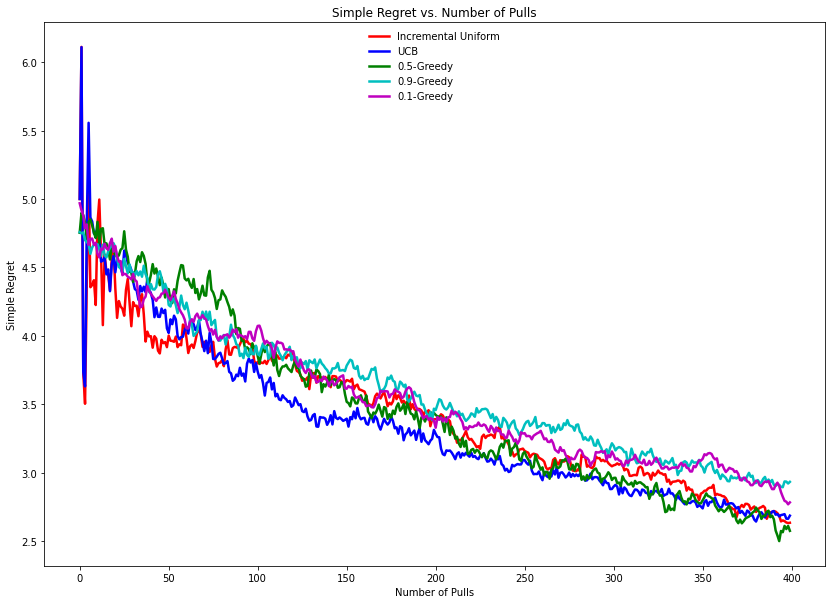

In [15]:
plot(range(TT_PULLS), [mean_simple_regret_0, mean_simple_regret_1, mean_simple_regret_2, 
                       mean_simple_regret_3, mean_simple_regret_4], name='Simple Regret')
del mean_simple_regret_0, mean_simple_regret_1, mean_simple_regret_2, mean_simple_regret_3, mean_simple_regret_4

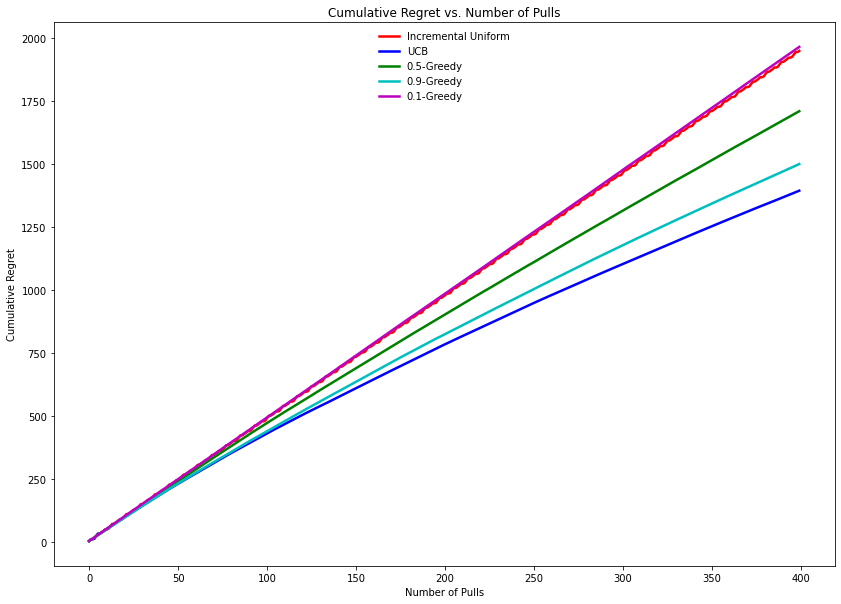

In [16]:
plot(range(TT_PULLS), [mean_cumulative_regret_0, mean_cumulative_regret_1, mean_cumulative_regret_2, 
                       mean_cumulative_regret_3, mean_cumulative_regret_4], name='Cumulative Regret')
del mean_cumulative_regret_0, mean_cumulative_regret_1, mean_cumulative_regret_2, mean_cumulative_regret_3, mean_cumulative_regret_4

### Influence of NUM_ARMS

In [12]:
##experiments settings
NUM_ARMS = 4 #number of arms

mu_0, std_0 = 5, 10  #first arm Gaussian's parameters
mu_1, std_1 = 3, 2
mu_2, std_2 = 10, 3
low_3, high_3 = 0, 1 #last arm draws from uninofrm [0, 1)
#the rewards are the drawn samples times 10 ([0, 1])
Arm_parameters = [(mu_0, std_0), (mu_1, std_1), (mu_2, std_2), (low_3, low_3)]



#the expected reward of every arm is its mu value, except the 8-th arm its expected reward is 5
Arms_expected_rewards = [mu_0, mu_1, mu_2, 5]
print("Arms_expected_rewards: ", Arms_expected_rewards)

#the optimal arm is 2 because it gives the expected reward of 10 with a small std 1
Opt_arm_expected_reward = Arms_expected_rewards[2]

Arms_expected_rewards:  [5, 3, 10, 5]


In [13]:
run_alg_exp(algorithm=0, printt=False, returnn=False)
run_alg_exp(algorithm=1, printt=False, returnn=False)
run_alg_exp(algorithm=2, epsilon=0.5, printt=False, returnn=False)
run_alg_exp(algorithm=2, epsilon=0.9, printt=False, returnn=False)
run_alg_exp(algorithm=2, epsilon=0.1, printt=False, returnn=False)

<ipython-input-3-ce05afe6ed8f>:74: RuntimeWarning: invalid value encountered in true_divide
  average_rewards = np.divide(running_sum_rewards, num_pulls) #update avg rewards


Best arms: 
Counter({2.0: 791, 1.0: 192, 3.0: 9, 0.0: 8})
Best arms: 
Counter({2.0: 670, 1.0: 262, 0.0: 34, 3.0: 34})
Best arms: 
Counter({2.0: 806, 1.0: 183, 0.0: 7, 3.0: 4})
Best arms: 
Counter({2.0: 705, 1.0: 264, 0.0: 17, 3.0: 14})
Best arms: 
Counter({2.0: 743, 1.0: 216, 0.0: 27, 3.0: 14})


In [14]:
##experiments settings
NUM_ARMS = 12 #number of arms

mu_0, std_0 = 5, 10  #first arm Gaussian's parameters
mu_1, std_1 = 3, 2
mu_2, std_2 = 10, 3
mu_3, std_3 = 7, 5
mu_4, std_4 = 0, 5
mu_5, std_5 = 1, 1
mu_6, std_6 = 10, 10
mu_7, std_7 = 9, 6
mu_8, std_8 = 3, 12
mu_9, std_9 = 8, 13
mu_10, std_10 = 8, 5
low_11, high_11 = 0, 1 #last arm draws from uninofrm [0, 1)
#the rewards are the drawn samples times 10 ([0, 1])
Arm_parameters = [(mu_0, std_0), (mu_1, std_1), (mu_2, std_2), (mu_3, std_3),
                  (mu_4, std_4), (mu_5, std_5), (mu_6, std_6), (mu_7, std_7),
                  (mu_8, std_8), (mu_9, std_9), (mu_10, std_10), (low_11, high_11)]



#the expected reward of every arm is its mu value, except the 8-th arm its expected reward is 5
Arms_expected_rewards = [mu_0, mu_1, mu_2, mu_3, mu_4, mu_5, mu_6, mu_7, mu_8, mu_9, mu_10, 5]
print("Arms_expected_rewards: ", Arms_expected_rewards)

#the optimal arm is 2 because it gives the expected reward of 10 with a small std 1
Opt_arm_expected_reward = Arms_expected_rewards[2]

Arms_expected_rewards:  [5, 3, 10, 7, 0, 1, 10, 9, 3, 8, 8, 5]


In [15]:
run_alg_exp(algorithm=0, printt=False, returnn=False)
run_alg_exp(algorithm=1, printt=False, returnn=False)
run_alg_exp(algorithm=2, epsilon=0.5, printt=False, returnn=False)
run_alg_exp(algorithm=2, epsilon=0.9, printt=False, returnn=False)
run_alg_exp(algorithm=2, epsilon=0.1, printt=False, returnn=False)

<ipython-input-3-ce05afe6ed8f>:74: RuntimeWarning: invalid value encountered in true_divide
  average_rewards = np.divide(running_sum_rewards, num_pulls) #update avg rewards


Best arms: 
Counter({2.0: 442, 1.0: 143, 5.0: 97, 10.0: 61, 3.0: 56, 7.0: 54, 6.0: 36, 9.0: 33, 0.0: 22, 11.0: 21, 8.0: 19, 4.0: 16})
Best arms: 
Counter({2.0: 524, 1.0: 160, 5.0: 123, 10.0: 43, 3.0: 36, 7.0: 32, 8.0: 20, 6.0: 14, 11.0: 14, 9.0: 13, 4.0: 12, 0.0: 9})
Best arms: 
Counter({2.0: 511, 1.0: 147, 5.0: 101, 10.0: 47, 7.0: 44, 3.0: 38, 6.0: 28, 9.0: 23, 11.0: 20, 8.0: 16, 0.0: 13, 4.0: 12})
Best arms: 
Counter({2.0: 431, 1.0: 178, 5.0: 109, 10.0: 52, 3.0: 49, 7.0: 41, 6.0: 35, 9.0: 28, 11.0: 23, 0.0: 21, 8.0: 20, 4.0: 13})
Best arms: 
Counter({2.0: 410, 1.0: 163, 5.0: 102, 10.0: 75, 3.0: 57, 7.0: 51, 9.0: 31, 6.0: 25, 0.0: 24, 4.0: 22, 8.0: 21, 11.0: 19})
